# 使用块的网络（VGG）
:label:`sec_vgg`

虽然AlexNet证明深层神经网络卓有成效，但它没有提供一个通用的模板来指导后续的研究人员设计新的网络。
在下面的几个章节中，我们将介绍一些常用于设计深层神经网络的启发式概念。

与芯片设计中工程师从放置晶体管到逻辑元件再到逻辑块的过程类似，神经网络架构的设计也逐渐变得更加抽象。研究人员开始从单个神经元的角度思考问题，发展到整个层，现在又转向块，重复层的模式。

使用块的想法首先出现在牛津大学的[视觉几何组（visual geometry group）](http://www.robots.ox.ac.uk/~vgg/)的*VGG网络*中。通过使用循环和子程序，可以很容易地在任何现代深度学习框架的代码中实现这些重复的架构。

## (**VGG块**)

经典卷积神经网络的基本组成部分是下面的这个序列：

1. 带填充以保持分辨率的卷积层；
1. 非线性激活函数，如ReLU；
1. 汇聚层，如最大汇聚层。

而一个VGG块与之类似，由一系列卷积层组成，后面再加上用于空间下采样的最大汇聚层。在最初的VGG论文中 :cite:`Simonyan.Zisserman.2014`，作者使用了带有$3\times3$卷积核、填充为1（保持高度和宽度）的卷积层，和带有$2 \times 2$汇聚窗口、步幅为2（每个块后的分辨率减半）的最大汇聚层。在下面的代码中，我们定义了一个名为`vgg_block`的函数来实现一个VGG块。


该函数有两个参数，分别对应于卷积层的数量`num_convs`和输出通道的数量`num_channels`.


In [1]:
import tensorflow as tf
from d2l import tensorflow as d2l


def vgg_block(num_convs, num_channels):
    blk = tf.keras.models.Sequential()
    for _ in range(num_convs):
        blk.add(tf.keras.layers.Conv2D(num_channels,kernel_size=3,
                                    padding='same',activation='relu'))
    blk.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
    return blk

## [**VGG网络**]

与AlexNet、LeNet一样，VGG网络可以分为两部分：第一部分主要由卷积层和汇聚层组成，第二部分由全连接层组成。如 :numref:`fig_vgg`中所示。

![从AlexNet到VGG，它们本质上都是块设计。](../img/vgg.svg)
:width:`400px`
:label:`fig_vgg`

VGG神经网络连接 :numref:`fig_vgg`的几个VGG块（在`vgg_block`函数中定义）。其中有超参数变量`conv_arch`。该变量指定了每个VGG块里卷积层个数和输出通道数。全连接模块则与AlexNet中的相同。

原始VGG网络有5个卷积块，其中前两个块各有一个卷积层，后三个块各包含两个卷积层。
第一个模块有64个输出通道，每个后续模块将输出通道数量翻倍，直到该数字达到512。由于该网络使用8个卷积层和3个全连接层，因此它通常被称为VGG-11。


In [2]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

下面的代码实现了VGG-11。可以通过在`conv_arch`上执行for循环来简单实现。


In [3]:
def vgg(conv_arch):
    net = tf.keras.models.Sequential()
    # 卷积层部分
    for (num_convs, num_channels) in conv_arch:
        net.add(vgg_block(num_convs, num_channels))
    # 全连接层部分
    net.add(tf.keras.models.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10)]))
    return net

net = vgg(conv_arch)

2025-04-18 15:23:29.445793: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-18 15:23:29.453498: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-18 15:23:29.455264: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-18 15:23:29.457543: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

接下来，我们将构建一个高度和宽度为224的单通道数据样本，以[**观察每个层输出的形状**]。


In [4]:
X = tf.random.uniform((1, 224, 224, 1))
for blk in net.layers:
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t', X.shape)

2025-04-18 15:23:30.470076: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


Sequential output shape:	 (1, 112, 112, 64)
Sequential output shape:	 (1, 56, 56, 128)


2025-04-18 15:23:31.640927: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2025-04-18 15:23:31.640964: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2025-04-18 15:23:31.836350: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2025-04-18 15:23:31.836388: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Alloc

Sequential output shape:	 (1, 28, 28, 256)
Sequential output shape:	 (1, 14, 14, 512)
Sequential output shape:	 (1, 7, 7, 512)
Sequential output shape:	 (1, 10)


正如从代码中所看到的，我们在每个块的高度和宽度减半，最终高度和宽度都为7。最后再展平表示，送入全连接层处理。

## 训练模型

[**由于VGG-11比AlexNet计算量更大，因此我们构建了一个通道数较少的网络**]，足够用于训练Fashion-MNIST数据集。


In [5]:
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
# 回想一下，这必须是一个将被放入“d2l.train_ch6()”的函数，为了利用我们现有的CPU/GPU设备，这样模型构建/编译需要在strategy.scope()中
net = lambda: vgg(small_conv_arch)

除了使用略高的学习率外，[**模型训练**]过程与 :numref:`sec_alexnet`中的AlexNet类似。


2025-04-18 15:23:32.803435: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_FLOAT
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 60000
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 28
        }
        dim {
          size: 28
        }
        dim {
          size: 1
        }
      }
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODU

ResourceExhaustedError: Graph execution error:

Detected at node 'sequential_7/sequential_10/max_pooling2d_7/MaxPool' defined at (most recent call last):
    File "/home/coraed/miniconda3/envs/d2l/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/coraed/miniconda3/envs/d2l/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/coraed/miniconda3/envs/d2l/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "/home/coraed/miniconda3/envs/d2l/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance
      app.start()
    File "/home/coraed/miniconda3/envs/d2l/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start
      self.io_loop.start()
    File "/home/coraed/miniconda3/envs/d2l/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "/home/coraed/miniconda3/envs/d2l/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/coraed/miniconda3/envs/d2l/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/coraed/miniconda3/envs/d2l/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/coraed/miniconda3/envs/d2l/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "/home/coraed/miniconda3/envs/d2l/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "/home/coraed/miniconda3/envs/d2l/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
      await result
    File "/home/coraed/miniconda3/envs/d2l/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "/home/coraed/miniconda3/envs/d2l/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "/home/coraed/miniconda3/envs/d2l/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "/home/coraed/miniconda3/envs/d2l/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/coraed/miniconda3/envs/d2l/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3048, in run_cell
      result = self._run_cell(
    File "/home/coraed/miniconda3/envs/d2l/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3103, in _run_cell
      result = runner(coro)
    File "/home/coraed/miniconda3/envs/d2l/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/coraed/miniconda3/envs/d2l/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3308, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/coraed/miniconda3/envs/d2l/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3490, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/coraed/miniconda3/envs/d2l/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_54002/3357625958.py", line 3, in <module>
      d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())
    File "/home/coraed/miniconda3/envs/d2l/lib/python3.9/site-packages/d2l/tensorflow.py", line 485, in train_ch6
      net.fit(train_iter, epochs=num_epochs, verbose=0, callbacks=[callback])
    File "/home/coraed/miniconda3/envs/d2l/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/coraed/miniconda3/envs/d2l/lib/python3.9/site-packages/keras/engine/training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/coraed/miniconda3/envs/d2l/lib/python3.9/site-packages/keras/engine/training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "/home/coraed/miniconda3/envs/d2l/lib/python3.9/site-packages/keras/engine/training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/coraed/miniconda3/envs/d2l/lib/python3.9/site-packages/keras/engine/training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "/home/coraed/miniconda3/envs/d2l/lib/python3.9/site-packages/keras/engine/training.py", line 859, in train_step
      y_pred = self(x, training=True)
    File "/home/coraed/miniconda3/envs/d2l/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/coraed/miniconda3/envs/d2l/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/coraed/miniconda3/envs/d2l/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/coraed/miniconda3/envs/d2l/lib/python3.9/site-packages/keras/engine/sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "/home/coraed/miniconda3/envs/d2l/lib/python3.9/site-packages/keras/engine/functional.py", line 451, in call
      return self._run_internal_graph(
    File "/home/coraed/miniconda3/envs/d2l/lib/python3.9/site-packages/keras/engine/functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/coraed/miniconda3/envs/d2l/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/coraed/miniconda3/envs/d2l/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/coraed/miniconda3/envs/d2l/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/coraed/miniconda3/envs/d2l/lib/python3.9/site-packages/keras/engine/sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "/home/coraed/miniconda3/envs/d2l/lib/python3.9/site-packages/keras/engine/functional.py", line 451, in call
      return self._run_internal_graph(
    File "/home/coraed/miniconda3/envs/d2l/lib/python3.9/site-packages/keras/engine/functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/coraed/miniconda3/envs/d2l/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/coraed/miniconda3/envs/d2l/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/coraed/miniconda3/envs/d2l/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/coraed/miniconda3/envs/d2l/lib/python3.9/site-packages/keras/layers/pooling.py", line 357, in call
      outputs = self.pool_function(
Node: 'sequential_7/sequential_10/max_pooling2d_7/MaxPool'
OOM when allocating tensor with shape[128,64,28,28] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_7/sequential_10/max_pooling2d_7/MaxPool}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_1853]

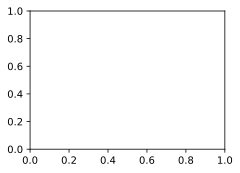

In [6]:
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

这是典型的GPU内存不足（OOM: Out of Memory）错误。错误消息显示：

```
OOM when allocating tensor with shape[128,32,112,112] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
```

问题分析：
1. 您使用的是NVIDIA GeForce GTX 1650显卡，只有1608MB显存
2. 您尝试训练的模型输入大小是224×224（从`resize=224`参数可知）
3. 批量大小设置为128，这对于您的GPU显存来说太大了
4. 模型中的卷积层需要分配[128,32,112,112]形状的张量，超出了可用显存

解决方案：

1. **减小批量大小**（最直接有效）：
   ```python
   # 将批量大小从128减小到更小的值
   lr, num_epochs, batch_size = 0.05, 10, 16  # 或者8、4等
   ```

2. **减小输入图像尺寸**：
   ```python
   # 将resize参数从224减小到更小的值
   train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=64)  # 或更小
   ```

3. **使用混合精度训练**：
   ```python
   # 在代码开头添加
   from tensorflow.keras.mixed_precision import experimental as mixed_precision
   policy = mixed_precision.Policy('mixed_float16')
   mixed_precision.set_global_policy(policy)
   ```

4. **强制使用CPU**（如果不在意训练速度）：
   ```python
   import os
   os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
   # 然后修改train_ch6调用
   d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_cpu())
   ```

建议首先尝试方案1和2的组合，将批量大小减小到16或8，并将图像尺寸减小到64或32，这通常能解决大多数OOM问题。


loss 0.141, train acc 0.948, test acc 0.917
1811.4 examples/sec on /GPU:0


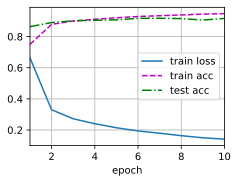

In [7]:
   # 将批量大小从128减小到更小的值
lr, num_epochs, batch_size = 0.05, 10, 16  # 或者8、4等
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=64)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## 小结

* VGG-11使用可复用的卷积块构造网络。不同的VGG模型可通过每个块中卷积层数量和输出通道数量的差异来定义。
* 块的使用导致网络定义的非常简洁。使用块可以有效地设计复杂的网络。
* 在VGG论文中，Simonyan和Ziserman尝试了各种架构。特别是他们发现深层且窄的卷积（即$3 \times 3$）比较浅层且宽的卷积更有效。

## 练习

1. 打印层的尺寸时，我们只看到8个结果，而不是11个结果。剩余的3层信息去哪了？
1. 与AlexNet相比，VGG的计算要慢得多，而且它还需要更多的显存。分析出现这种情况的原因。
1. 尝试将Fashion-MNIST数据集图像的高度和宽度从224改为96。这对实验有什么影响？
1. 请参考VGG论文 :cite:`Simonyan.Zisserman.2014`中的表1构建其他常见模型，如VGG-16或VGG-19。


[Discussions](https://discuss.d2l.ai/t/1865)
